In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors
from matplotlib.colors import LogNorm

%matplotlib inline
from scipy.optimize import curve_fit, minimize
#import strax
import straxbra
from matplotlib.ticker import AutoMinorLocator
from matplotlib.image import NonUniformImage
import pandas as pd

In [5]:
ctx = straxbra.XebraContext()
run = '00192'
# peaks_data_xebra = ctx.get_array(run, 'peaks')
# ncomp = ctx.get_array(run, 'n_competing')
event_basics = ctx.get_array(run, 'event_info')
# records_data = ctx.get_array(run, 'records')
# raw_records_data = ctx.get_array(run, 'raw_records')
ctx.data_info('peaks')
ctx.data_info('n_competing')
ctx.data_info('event_basics')

KeyError: 'cathode_mean'

In [4]:
ctx.data_info('event_info')

,Field name,Data type,Comment
0,event_number,int64,Event number in this dataset
1,time,int64,Event start time in ns since the unix epoch
2,endtime,int64,Event end time in ns since the unix epoch
3,n_peaks,int32,Number of peaks in the event
4,drift_time,int64,Drift time between main S1 and S2 in ns
5,s1_index,int32,Main S1 peak index
6,s1_area,float32,"Main S1 area (PE), uncorrected"
7,s1_area_b,float32,"Main S1 area (PE), uncorrected, bottom PMTs only"
8,s1_area_fraction_top,float32,Main S1 area fraction top
9,s1_range_50p_area,float32,"Main S1 width (ns, 50% area)"


In [3]:
# ctx.data_info('n_competing')

In [4]:
# ctx.data_info('event_basics')

In [5]:
# ctx.data_info('records')

In [6]:
S1_area = event_basics['s1_area']
S2_area = event_basics['s2_area']

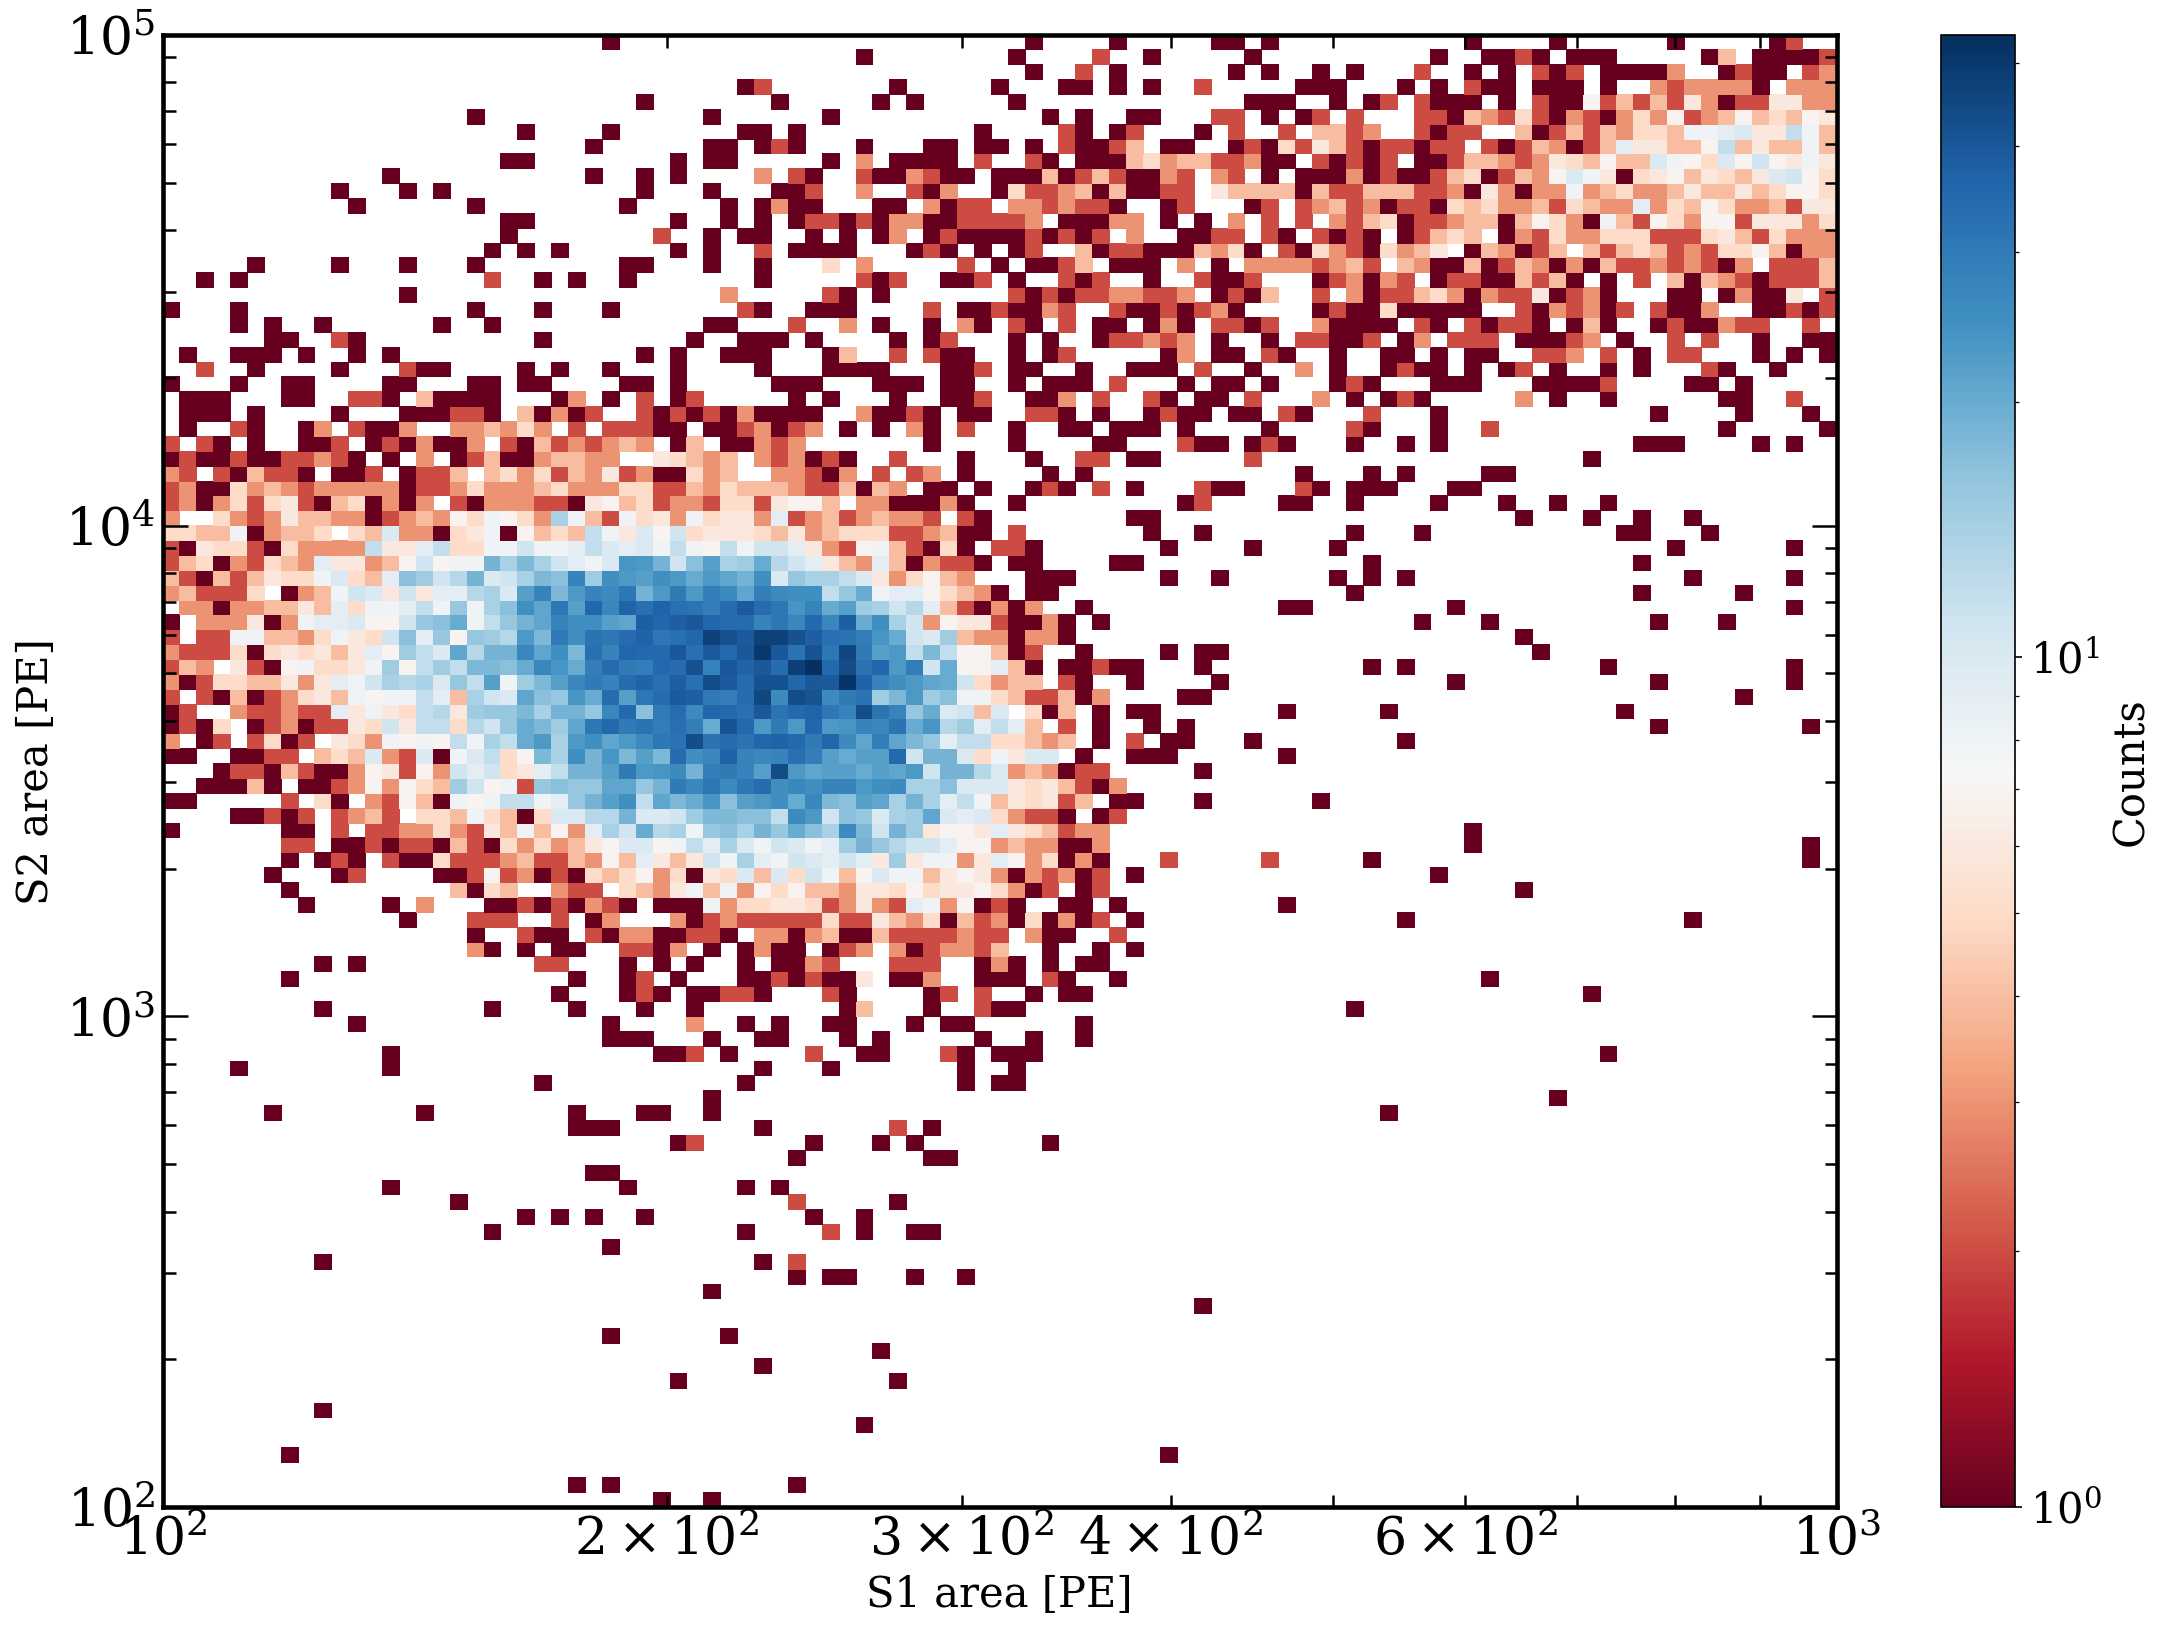

In [8]:
fig=plt.figure(figsize=(18, 13), dpi=150)

# Text options
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

# Labels
label_size = 25 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)


bins_x = np.logspace(2,3,100)
bins_y = np.logspace(2,5,100)
histo_max= 2*10**3

counts, _, _ = np.histogram2d(S1_area, S2_area, bins=(bins_x, bins_y))

im = axes.pcolormesh(bins_x, bins_y, counts.T, cmap='RdBu', norm=mcolors.LogNorm())
axes.set_xlabel('S1 area [PE]', fontsize = 20)
axes.set_ylabel('S2 area [PE]', fontsize = 20)

#ax.set_title(' xxx', fontsize= 15)
# axes.tick_params(axis='both', which='major', labelsize=15)

axes.set_xscale('log')
axes.set_yscale('log')
cbar = plt.colorbar(im, ax=axes)
cbar.set_label('Counts',size=20)
cbar.ax.tick_params(labelsize=20) 
# cbar.axes.tick_params(labelsize=15)
# cbar.set_label(label ='Counts/Bin', fontsize=15)
plt.show()

In [ ]:
# plt.figure(figsize=(18,13))
# plt.hist(ncomp['n_competing'], bins=np.arange(20))
# plt.show()

In [ ]:
line = event_basics[(100<event_basics['s1_area']) & (event_basics['s1_area'] < 300)]
fig, ax = plt.subplots(figsize=(18,13))

bins_x = np.linspace(0,50,50)
bins_y = np.logspace(1,4.5,50)
counts, xedges, yedges = np.histogram2d(line['drift_time']/1e3, line['s2_area'], bins=(bins_x, bins_y))
print(line['drift_time']/1e3)
im = ax.pcolormesh(bins_x, bins_y, counts.T, norm=LogNorm(), cmap = 'RdBu')
plt.colorbar(im,ax=ax, label='Counts/bin')
ax.set_yscale('log')

ax.set_xlabel('Drift time [us]')
ax.set_ylabel('S2')
plt.show()

In [ ]:
xcenter = ((xedges[:-1]+xedges[1:])/2)
ycenter = ((yedges[:-1]+yedges[1:])/2)
# print(xcenter)
# print(ycenter)

In [ ]:
fig, ax = plt.subplots(figsize=(18,13))
fit_range= np.linspace(10,30000,1000)

def single_gaus(x, h, mu, sigma):

    gaus = h * np.exp(-(np.log(x)-mu)**2         /(2*sigma**2))
    return gaus
p0 = [60,8,8]
mu_list = []
mu_error_list = []
# popt, pcov = curve_fit(single_gaus, ycenter, counts[27], p0)
# plt.scatter(ycenter, counts[27], c = 'r', marker = 'x')
# plt.plot(fit_range, single_gaus(fit_range, *popt))
ax.set_xscale('log')
ax.set_title('Fit for each drift time slice - log(gaus) fit', fontsize = 20)
ax.set_xlabel('S2 area [PE]', fontsize = 20)
ax.set_ylabel('counts[#]', fontsize = 20)
for i in range(5,35):   
    popt, pcov = curve_fit(single_gaus, ycenter, counts[i], p0)
    plt.plot(fit_range, single_gaus(fit_range, *popt))
    #value = np.exp(popt[1])
    value = np.exp(popt[1]+((popt[2]**2)/2))
    mu_list.append(value)
    perr = np.sqrt(np.diag(pcov))
    error_ln_mu = perr[1]
    error_mu = np.exp(popt[1])*error_ln_mu
    mu_error_list.append(error_mu)


plt.show()




In [ ]:
print(counts[30])


In [ ]:
def expo(x, a, b):
    return a*np.exp(-b*x)

fig, ax =plt.subplots(figsize = (18,13))
p0=  [10000,0.1]
x = np.linspace(5,35,30)
y_values = mu_list
y_error = mu_error_list
SIZE = 20
EXTRA_SIZE = 30

plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=EXTRA_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)

popt, pcov = curve_fit(expo, x, y_values, sigma=y_error, p0=p0, absolute_sigma=True, maxfev= 10000)
# lifetime = 1/popt[1]
# lifetime_error = (1/(popt[1]**2))*perr[1]
lifetime = "%.2f" % (1/popt[1]*np.log(2))
lifetime_error = "%.2f" % ((1/(popt[1]**2))*perr[1])

plt.errorbar(x, y_values, yerr=y_error, xerr=0, fmt = 'rx', label = 'average S2 size' )

print('this is lamba: ', popt[1])
print('this is 1/lamba: ', 1/popt[1] )
plt.plot(x, expo(x, *popt), 'g--', label = 'electron lifetime = '+str(lifetime)+ ' +/- '+str(lifetime_error)+' us')
# print(y_error)


#ax.set_ylim([130,250])
ax.set_title('electron lifetime fit - Run '+run[2:]+' - Getter on')
ax.set_xlabel('Drift time [us]')
ax.set_ylabel('S2 area [PE]')


print('electron lifetime: ', lifetime, '+/-', lifetime_error)

# print(perr)
plt.legend(prop={'size': 20})
plt.show()


In [ ]:
line = event_basics[(100<event_basics['s1_area']) & (event_basics['s1_area'] < 300)]
fig, ax = plt.subplots(figsize=(18,13))

bins_x = np.linspace(0,50,50)
bins_y = np.logspace(1,5,50)
counts, xedges, yedges = np.histogram2d(line['drift_time']/1e3, line['s2_area'], bins=(bins_x, bins_y))

im = ax.pcolormesh(bins_x, bins_y, counts.T, norm=LogNorm(), cmap = 'RdBu')
plt.colorbar(im,ax=ax, label='Counts/bin')

plt.scatter(xcenter[5:35], y_values, c = 'r', marker = 'x', s =110)

ax.set_yscale('log')

ax.set_xlabel('Drift time [us]')
ax.set_ylabel('S2 area [PE]')
plt.show()

In [ ]:
# line = event_basics[(100<event_basics['s1_area']) & (event_basics['s1_area'] < 300)]
# fig, ax = plt.subplots(figsize=(18,13))

# bins_x = np.linspace(0,50,50)
# #bins_y = np.logspace(1,3.5,50)
# counts, binEdges = np.histogram(line['drift_time']/1e3, bins=bins_x)

# #ax.set_yscale('log')
# plt.hist(line['drift_time']/1e3, bins=bins_x, color='C5')
# ax.set_xlabel('Drift time [us]')
# ax.set_ylabel('S2')
# plt.show()

In [ ]:
eval('1'+'+2')

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors
from matplotlib.colors import LogNorm

%matplotlib inline
from scipy.optimize import curve_fit, minimize
import strax
import straxbra

In [ ]:
ctx = straxbra.XebraContext()

In [ ]:



run_list = ['00217', '00218', '00219', '00220', '00221', '00222', '00223', '00224', '00225', '00226', '00227']



Lifetime_list = []
Lifetime_error_list = []

for run in run_list:
    event_basics = ctx.get_array(run, 'event_basics')
    S1_area = event_basics['s1_area']
    S2_area = event_basics['s2_area']

    fig, ax = plt.subplots(figsize=(12,8))
    bins_x = np.logspace(0,5,100)
    bins_y = np.logspace(0,6,100)
    histo_max= 2*10**3

    counts, _, _ = np.histogram2d(S1_area, S2_area, bins=(bins_x, bins_y))
    im = ax.pcolormesh(bins_x, bins_y, counts.T, cmap='RdBu', norm=mcolors.LogNorm())
    ax.set_xlabel('S1 area [PE]', fontsize = 20)
    ax.set_ylabel('S2 area [PE]', fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xscale('log')
    ax.set_yscale('log')
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label(label ='Counts/Bin', fontsize=15)  
    
    line = event_basics[(100<event_basics['s1_area']) & (event_basics['s1_area'] < 300)]
    fig, ax = plt.subplots(figsize=(18,13))
    bins_x = np.linspace(0,50,50)
    bins_y = np.logspace(1,4.5,50)
    counts, xedges, yedges = np.histogram2d(line['drift_time']/1e3, line['s2_area'], bins=(bins_x, bins_y))
    print(line['drift_time']/1e3)
    im = ax.pcolormesh(bins_x, bins_y, counts.T, norm=LogNorm(), cmap = 'RdBu')
    plt.colorbar(im,ax=ax, label='Counts/bin')
    ax.set_yscale('log')
    ax.set_xlabel('Drift time [us]')
    ax.set_ylabel('S2')
    
    xcenter = ((xedges[:-1]+xedges[1:])/2)
    ycenter = ((yedges[:-1]+yedges[1:])/2)
    
    fig, ax = plt.subplots(figsize=(18,13))
    fit_range= np.linspace(10,30000,1000)

    def single_gaus(x, h, mu, sigma):

        gaus = h * np.exp(-(np.log(x)-mu)**2         /(2*sigma**2))
        return gaus
    p0 = [60,8,8]
    mu_list = []
    mu_error_list = []
    # popt, pcov = curve_fit(single_gaus, ycenter, counts[27], p0)
    # plt.scatter(ycenter, counts[27], c = 'r', marker = 'x')
    # plt.plot(fit_range, single_gaus(fit_range, *popt))
    ax.set_xscale('log')
    ax.set_title('Fit for each drift time slice - log(gaus) fit', fontsize = 20)
    ax.set_xlabel('S2 area [PE]', fontsize = 20)
    ax.set_ylabel('counts[#]', fontsize = 20)
    for i in range(5,35):   
        popt, pcov = curve_fit(single_gaus, ycenter, counts[i], p0)
        plt.plot(fit_range, single_gaus(fit_range, *popt))
        #value = np.exp(popt[1])
        value = np.exp(popt[1]+((popt[2]**2)/2))
        mu_list.append(value)
        perr = np.sqrt(np.diag(pcov))
        error_ln_mu = perr[1]
        error_mu = np.exp(popt[1])*error_ln_mu
        mu_error_list.append(error_mu)


    def expo(x, a, b):
        return a*np.exp(-b*x)

    fig, ax =plt.subplots(figsize = (18,13))
    p0=  [10000,0.1]
    x = np.linspace(5,35,30)
    y_values = mu_list
    y_error = mu_error_list

    SIZE = 20
    EXTRA_SIZE = 30

    plt.rc('font', size=SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=EXTRA_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE)    # legend fontsize
    plt.rc('figure', titlesize=SIZE)
    
    popt, pcov = curve_fit(expo, x, y_values, sigma=y_error, p0=p0, absolute_sigma=True, maxfev= 10000)
    # lifetime = 1/popt[1]
    # lifetime_error = (1/(popt[1]**2))*perr[1]
    lifetime = "%.2f" % (1/popt[1]*np.log(2))
    lifetime_error = "%.2f" % ((1/(popt[1]**2))*perr[1])

    plt.errorbar(x, y_values, yerr=y_error, xerr=0, fmt = 'rx', label = 'average S2 size' )

    print('this is lamba: ', popt[1])
    print('this is 1/lamba: ', 1/popt[1] )
    plt.plot(x, expo(x, *popt), 'g--', label = 'electron lifetime = '+str(lifetime)+ ' +/- '+str(lifetime_error)+' us')
    
    # print(y_error)


    #ax.set_ylim([130,250])
    ax.set_title('electron lifetime fit - Run 226 - Getter off')
    ax.set_xlabel('Drift time [us]')
    ax.set_ylabel('S2 area [PE]')


    print('electron lifetime: ', lifetime, '+/-', lifetime_error)
    # print(perr)
    plt.legend(prop={'size': 20})
    Lifetime_list.append(lifetime)
    Lifetime_error_list.append(lifetime_error)
    plt.show()




In [ ]:
print(Lifetime_list)
print(Lifetime_error_list)

In [ ]:

####218 -250 slices 5-35####
Lifetime_all = ['101.16', '66.59', '32.74', '20.82', '14.94', '11.39', '8.81', '7.43', '6.60','6.34', '6.52', '7.30', '8.71', '9.93', '11.51', '13.49', '15.63', '18.25', '20.34', '23.41', '25.90', '28.58', '32.21', '34.43', '38.71', '39.79', '43.02', '44.67', '47.59', '51.78', '53.92', '55.85', '56.98']
Lifetime_error_all = ['87.45', '68.37', '11.00', '14.27', '6.87', '3.34', '1.92', '2.50', '6.13', '7.53', '5.26', '3.53', '3.44', '2.63', '3.33', '4.88', '4.41', '5.52', '5.34', '5.25', '12.62', '7.84', '10.01', '15.85', '17.76', '16.83', '27.58', '23.74', '20.74', '29.11', '19.49', '31.84', '30.98']

 


Electron_lifetime_all = [float(i) for i in Lifetime_all] * 1/(np.log(2))
Electron_lifetime_error_all = [float(j) for j in Lifetime_error_all]


Time = [0,17,47,77,107,137,167,197,227, 240, 257,287, 317,347,377,407,437,467,497,527,557,587,617,647,677,707,737,767,797,827, 857,887,917]
Time_off = [0,17,47,77,107,137,167,197,227,240]
Time_on = [240, 257,287, 317,347,377,407,437,467,497,527,557,587,617,647,677,707,737,767,797,827, 857,887, 917]

######218 - 227 with slices 5-35######
Electron_lifetime_off = ['101.16', '66.59', '32.74', '20.82', '14.94', '11.39', '8.81', '7.43', '6.60','6.34']
Electron_lifetime_off_error = ['87.45', '68.37', '11.00', '14.27', '6.87', '3.34', '1.92', '2.50', '6.13','7.53']

######227 - 250 with slices 5-35######
Electron_lifetime_on = ['6.34', '6.52', '7.30', '8.71', '9.93', '11.51', '13.49', '15.63', '18.25', '20.34', '23.41', '25.90', '28.58', '32.21', '34.43', '38.71', '39.79', '43.02', '44.67', '47.59', '51.78', '53.92', '55.85', '56.98']
Electron_lifetime_on_error = ['7.53', '5.26', '3.53', '3.44', '2.63', '3.33', '4.88', '4.41', '5.52', '5.34', '5.25', '12.62', '7.84', '10.01', '15.85', '17.76', '16.83', '27.58', '23.74', '20.74', '29.11', '19.49', '31.84', '30.98']

Electron_lifetime_off = [float(i) for i in Electron_lifetime_off] * 1/(np.log(2))
Electron_lifetime_on = [float(j) for j in Electron_lifetime_on] * 1/(np.log(2))
Electron_lifetime_on = list(Electron_lifetime_on)
Electron_lifetime_off = list(Electron_lifetime_off)
Electron_lifetime_on_error = [float(i) for i in Electron_lifetime_on_error]
Electron_lifetime_off_error = [float(i) for i in Electron_lifetime_off_error]
print(len(Time))
print(Electron_lifetime_on)

In [ ]:
def expo(x, a, b,c):
    return a*np.exp(-b*x)+c

def gaus(x, h, mu, sigma):
    gaus = h * np.exp(-(x-mu)**2         /(2*sigma**2))
    return gaus

axis_range = np.linspace(0,100,100)
plt.plot(axis_range, gaus(axis_range,10,50,10), color = 'orange')
plt.show()

In [ ]:
# print(Time_off)
# print(Electron_lifetime_off)
# print(Electron_lifetime_off_error)

# def expo(x, a, b,c,d):
#     return a - b* (  np.exp(-((np.log(2))/c)*(x-d))   )

def expo_off(x, a, b):
    return a*np.exp(-b*x)

fig, ax =plt.subplots(figsize = (18,13))

p0= [100, 0.1]
bounds_off = ((0,0),(500, np.inf))

Time_range_on = np.linspace(240,917,100)
Time_range_off = np.linspace(0,240,100)


# Electron_lifetime_all = [x / 41 for x in Electron_lifetime_all]
# Electron_lifetime_error_all = [x / 41 for x in Electron_lifetime_error_all]
# Electron_lifetime_on = [x / 41 for x in Electron_lifetime_on]
# Electron_lifetime_off = [x / 41 for x in Electron_lifetime_off]
# Electron_lifetime_off_error = [x / 41 for x in Electron_lifetime_off_error]

popt_off, pcov_off = curve_fit(expo_off, Time_off, Electron_lifetime_off,sigma=Electron_lifetime_off_error, p0=p0, bounds = bounds_off, absolute_sigma=True, maxfev= 10000)
#popt_on, pcov_on = curve_fit(linear_on, Time_on, Electron_lifetime_on,sigma=Electron_lifetime_on_error, p0=p0, absolute_sigma=True, maxfev= 10000)
print(Electron_lifetime_all)



SIZE = 20
EXTRA_SIZE = 30

plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=EXTRA_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)



plt.errorbar(Time, Electron_lifetime_all, yerr=Electron_lifetime_error_all, xerr=0, ecolor='red', capsize=5, fmt = 'bx', label = 'average electron lifetime' )
plt.plot(Time_range_off, expo_off(Time_range_off, *popt_off), 'y--', label= 'getter off')

m,b = np.polyfit(Time_on,Electron_lifetime_on , 1)
print('fit parameters for linear fit are: ', 'm=',m , 'b= ',b)
m = "%.2f" % m
fit=np.polyfit(Time_on,Electron_lifetime_on , 1)
fit_fn = np.poly1d(fit)
plt.plot(Time_on, fit_fn(Time_on), 'g--', label = 'getter on: m = '+str(m))

ax.axvline(x=240, ymin=0, ymax=2, linestyle = '--', label ='start purification')
ax.set_title('Run 218-250 - 4 hours getter bypassed, 12 hours purification')
ax.set_xlabel('Time [min]')
ax.set_ylabel('lifetime [us]')
plt.legend(prop={'size': 20})
plt.show()